In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as col
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, LogLocator
import scipy.stats
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm, LinearSegmentedColormap
import matplotlib.lines as mlines
from plotpack import *
%matplotlib inline

# font size and style
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 45}
legsize = 40
axsize  = 22
marksize   = 13
majticklen = 20
minticklen = 10
tickwidth  = 5
matplotlib.rc('font', **font)

c1 = ['black', 'tab:blue', 'darkred', 'darkgreen', 'darkred', 'dimgray']
colors = ["darkred","red","darkorange", "yellow", "darkgreen", "lightseagreen", "cornflowerblue", "darkblue"]
nodes = [0.0, 0.22, 0.44, 0.65,0.673,0.675,0.8, 1.0]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
c        = ['black','darkgrey','rosybrown','#bae4bc','#7bccc4','#43a2ca','#0868ac', 'blue','midnightblue', 'slategrey']
labels   = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)','(9)','(10)']

/tmp/ipykernel_7621/2714647474.py:11: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
# 0 = oblate, 1 = cylinder, 2 = branched
directory = './experiments/'
var       = ['d1','d2','ce_boehm','ce_bulk','ce_spheres','rho_rime','vel_rel','St','N_Re',
             'N_ReBig','ce_BG','ce_Robin','ce_Slinn','ce_Holger']
#---------------------
fold    = ['oblate','cylinder','branched']
fname   = ['drop_spectrum','drop_spectrum','drop_spectrum']
caption = ['$r$ [ym]','$r$ [ym]','$r$ [ym]']
no      = [8,8,8]
maxx    = [100.,100.,100.]
maxy    = [1.05,1.05,1.05]
lo      = [2,5,5]
entries = [181,281,1601]
ref     = [True,True,True]                 # additional reference available?
N_Re    = [([1.,2.,10.,20.,35.,60.,90.,120.,]), 
           ([.2,.5,.7,1.,2.,5.,10.,20.]), 
           ([1.,2.,10.,20.,35.,60.,90.,120.,])]
interv  = [10,10,50]
anno    = ["(a)", "(b)", "(c)"]

In [3]:
def split_results(case):
    frames    = []
    curves2   = []
    os.system('csplit '+directory+       
        'colleff_riming_Fr000_rhor600_'+fname[case]+'_'+fold[case]+'.dat \
                   '+str(entries[case])+' {'+str(no[case]-1)+'} -f split. >/dev/null')
    os.system('sed "s/^[ \t]*//" -i split.*')

    filenames = ['split.00']
    for n in range(1,no[case]):
        name = 'split.0'+str(n)
        os.system('sed -i 1d '+ name )
        filenames.append(name)
    
    for f in filenames:
        frame = pd.read_csv(f, names=var, delimiter = " ")
        frame.reset_index(drop = True, inplace = True)
        frames.append(frame)
    #frames.append(pd.DataFrame([pd.read_csv(f, names=var, delimiter = " ") for f in filenames]) )
    #result = pd.concat(frames, keys=dir_n)
    for i in range(1,no[case]+1):
        f = '~/DWD/WJ_'+fold[case]+'/c'+str(i)+'.dat'
        df_temp = pd.read_csv(f, names=['r','Ec'], delimiter = ",", engine='python') 
        df_temp.reset_index(drop = True, inplace = True)
        curves2.append(df_temp)
    os.system('rm split*')
    return frames, curves2

In [4]:
result_pla, WJ_pla = split_results(0)
result_cyl, WJ_cyl = split_results(1)
result_bra, WJ_bra = split_results(2)

result_all = [result_pla,result_cyl,result_bra]
WJ_all     = [WJ_pla,WJ_cyl,WJ_bra]
#print(result_pla[1]['d2'])

/tmp/ipykernel_7621/2819135515.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(row,col,j+1)


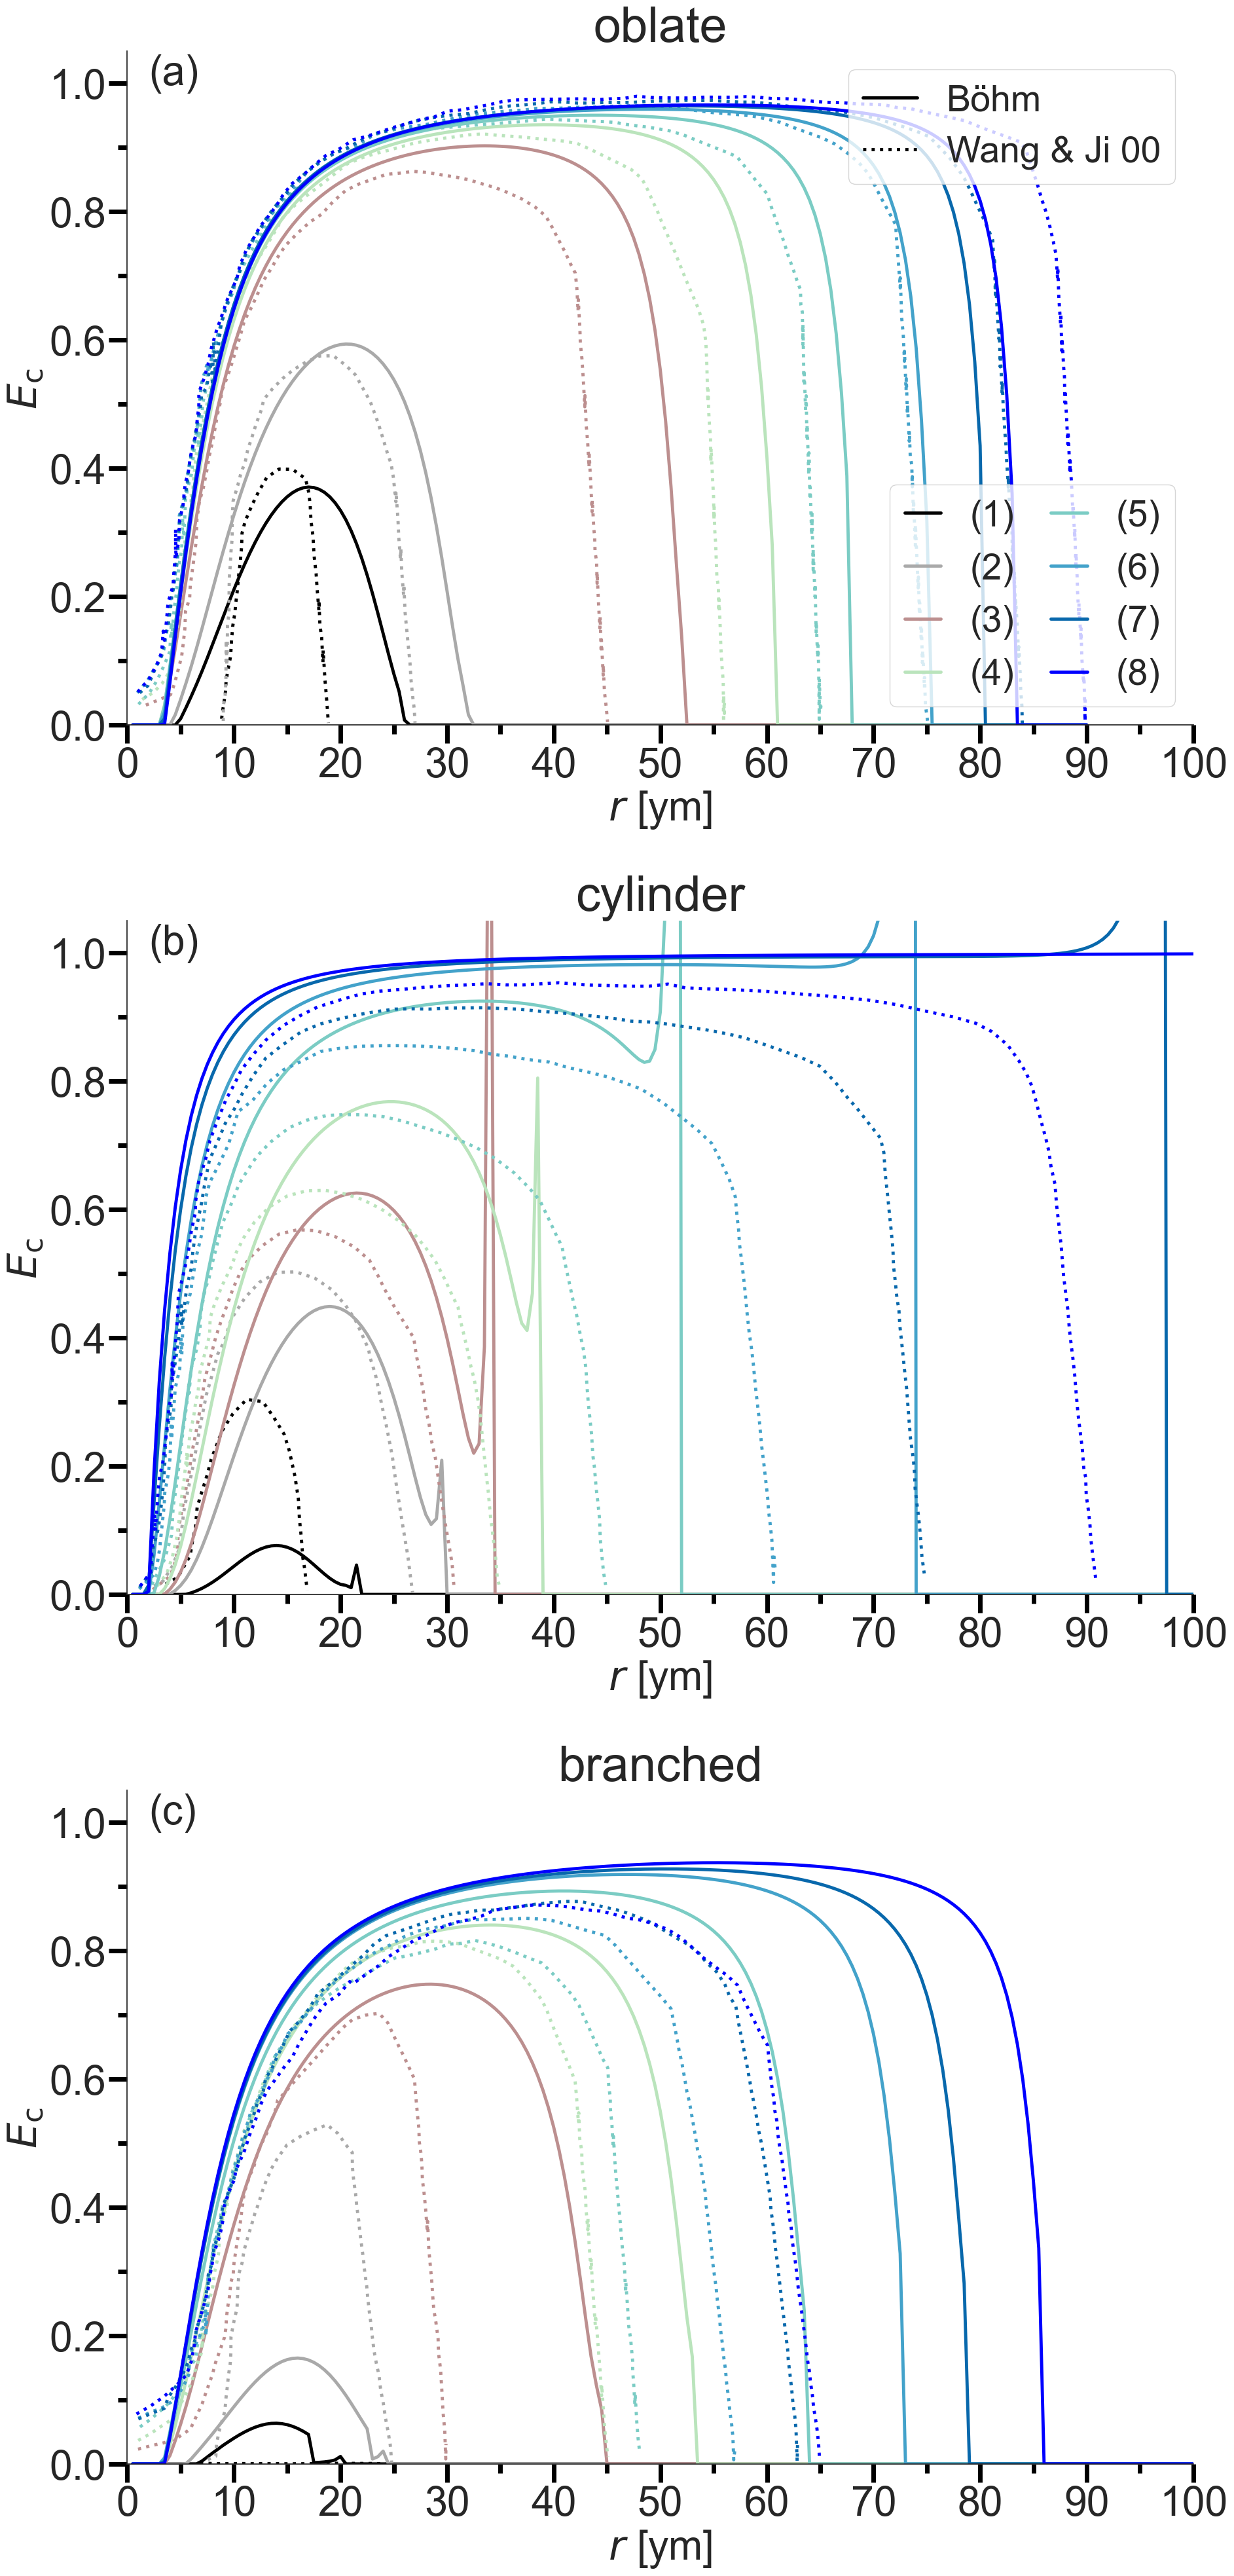

In [5]:
pp        = PdfPages('./PDFs/coll_efficiency_Boehm_all_v'+str(3)+'.pdf')
row, col = 3, 1
fig, axes = plt.subplots(figsize=(20*col,15*row))#, sharey = True)
fig.subplots_adjust(wspace=0.03, hspace=0)
k = 0
#--------------------------------------------------------------------------------------------------
for j in range(len(result_all)):
    # subplots
    ax1 = plt.subplot(row,col,j+1)
    ax1.set_title(fold[j])
    # ax1.set_title('Boehm',        fontsize=fsize-2)
    ax1.set_xlabel(caption[j])
    ax1.set_ylabel('$E_\mathrm{c}$')
    ax1.set_xlim(0.,maxx[j])
    ax1.set_ylim(0.0,maxy[j])
    ax1.set_xticks(np.arange(0, maxx[j]+10, interv[j]))
    ax1.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
    ax1.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')
    ax1.yaxis.set_minor_locator(MultipleLocator(base = .1))
    ax1.xaxis.set_minor_locator(MultipleLocator(base = 5))
    ax1.xaxis.set_major_locator(MultipleLocator(base =10))
    ax1.annotate(anno[j], xy=(0.02, 0.95), xycoords="axes fraction")
    for i in range(no[j]):
        Ec = result_all[j][i]['ce_boehm']
        d1 = result_all[j][i]['d1']
        d2 = result_all[j][i]['d2']
        vel = result_all[j][i]['vel_rel']
            # Ec = np.ma.masked_array(Ec, mask=( 0.5 * d2 > d1 ))
        l1, = ax1.plot(d2*5e5, Ec, color=c[i],label=labels[i])#+', $N_\mathrm{Re}=$'+str(N_Re[case][i]) )
        if ref[j] == True:
            l3, = ax1.plot(WJ_all[j][i]['r'], WJ_all[j][i]['Ec'],  color=c[i], linestyle='dotted', label='_nolegend_')
            #print(result.loc[dir_n[0]].loc[i][0]['N_ReBig'][0]/N_Re[case][i], result.loc[dir_n[0]].loc[i][0]['N_ReBig'][0] - N_Re[case][i])
    if (j == 0):
        leg = ax1.legend(fontsize = legsize,loc='lower right', ncol=2, columnspacing = 1, handlelength=1., frameon=True)
        legend2 = ax1.legend([l1, l3], ["Böhm", "Wang & Ji 00"], loc="upper right", ncol=1, fontsize = legsize, columnspacing = 1, handlelength=1.5, frameon=True)
        for lh in legend2.legendHandles: 
            lh.set_color('black')
        ax1.add_artist(leg)
#--------------------------------------------------------------------------------------------------

plt.tight_layout(rect=[0, 0.0, 1, 0.9])
pp.savefig(bbox_inches = 'tight', pad_inches = 0.5)


In [6]:
pp.close()